In [ ]:
import os

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Set Path

In [ ]:
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'CW_Folder_PG'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['.DS_Store', 'CW_Dataset', 'Models', 'Code', 'Video', 'test_functions.ipynb']


# Load images and labels

In [ ]:
import skimage.io
import pandas as pd
import os

def load_images_and_labels(image_folder_path, label_folder_path):

    # create list of images and labels
    images = []
    labels = []

    # get a list of images from folder path
    image_files = sorted(os.listdir(image_folder_path))
    # get a list of labels from folder path
    label_files = sorted(os.listdir(label_folder_path))

    # reference: https://stackoverflow.com/questions/30230592/loading-all-images-using-imread-from-a-given-folder
    # iterate through images
    for image_filename in image_files:
        if image_filename.endswith('.jpeg'):
            # make sure images and labels correspond to each other
            label_filename = image_filename.replace('.jpeg', '.txt')
            label_path = os.path.join(label_folder_path, label_filename)

            # check if label file exists
            if label_filename in label_files:
                image_path = os.path.join(image_folder_path, image_filename)
                # load images
                img = skimage.io.imread(image_path)
                if img is not None:
                    images.append(img)

                    # load labels
                    with open(label_path, 'r') as file:
                        label = file.read().strip()
                        labels.append(label)

    return images, labels

# paths where train and test datasets are located
train_images_load_path = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset/train/images')
train_labels_load_path = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset/train/labels')
test_images_load_path = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset/test/images')
test_labels_load_path = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset/test/labels')

# load train images and labels
train_images, train_labels = load_images_and_labels(train_images_load_path, train_labels_load_path)

# load test images and labels
test_images, test_labels = load_images_and_labels(test_images_load_path, test_labels_load_path)

## Save to pkl files for faster access

In [ ]:
import pickle

# set paths to save pkl files to
train_data_path = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset/train_data.pkl')
test_data_path = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset/test_data.pkl')

# save train data as pkl file
with open(train_data_path, 'wb') as f:
    pickle.dump((train_images, train_labels), f)

# save test data as pkl file
with open(test_data_path, 'wb') as f:
    pickle.dump((test_images, test_labels), f)

## Load images and labels from pkl files

In [ ]:
import pickle

# set paths where the pkl files are located
train_data_path = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset/train_data.pkl')
test_data_path = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset/test_data.pkl')

# load train data
with open(train_data_path, 'rb') as f:
    train_images, train_labels = pickle.load(f)

# load test data
with open(test_data_path, 'rb') as f:
    test_images, test_labels = pickle.load(f)

### Check that images and labels loaded correctly

In [ ]:
print(len(train_images))
print(len(train_labels))
print(len(test_images))
print(len(test_labels))

2394
2394
458
458


In [ ]:
print(train_images[0].shape) # get image shape

(27, 23, 3)


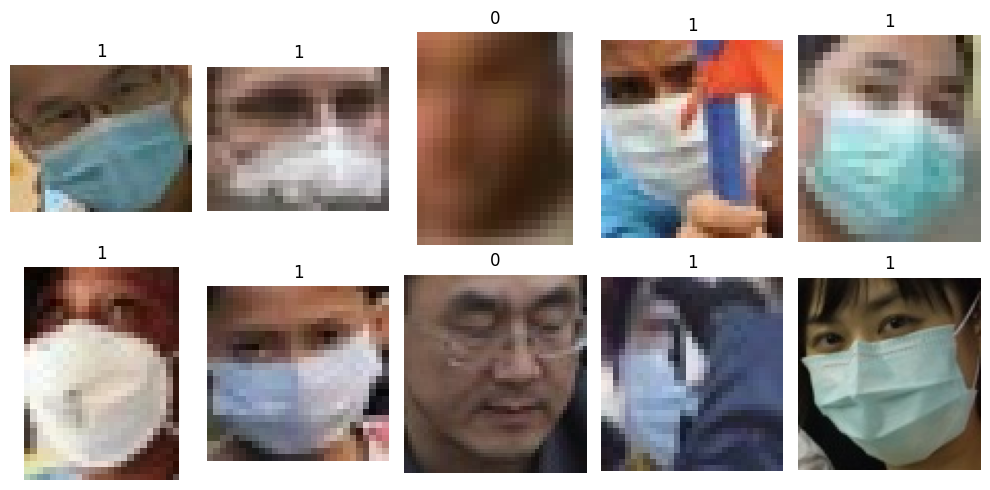

In [ ]:
import matplotlib.pyplot as plt
import random

# get 10 random images in the train images
random_indices = random.sample(range(len(train_images)), 10)

# display the 10 random images with labels
fig, axes = plt.subplots(2, 5, figsize=(10, 5))

for i, ax in enumerate(axes.flat):
    ax.imshow(train_images[random_indices[i]])
    ax.set_title(train_labels[random_indices[i]])
    ax.axis('off')

plt.tight_layout()
plt.show()

# Data preprocessing

Split train data into training and validation set

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

# split train data into 80% training and  20% validation
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)



In [ ]:
from collections import Counter

# get class distribution count in train
train_label_counts = Counter(train_labels)

# get class distribution count in val
val_label_counts = Counter(val_labels)

print("Train Label Counts:", train_label_counts)
print("Validation Label Counts:", val_label_counts)


Train Label Counts: Counter({'1': 1539, '0': 314, '2': 62})
Validation Label Counts: Counter({'1': 401, '0': 62, '2': 16})


Check image size

In [ ]:
# variables to store total width and height
total_width = 0
total_height = 0
total_images = 0

# iterate through the train images folder
for filename in os.listdir(train_images_load_path):
        # read image
        image = skimage.io.imread(os.path.join(train_images_load_path, filename))
        # add width, height and count of image
        total_width += image.shape[1]
        total_height += image.shape[0]
        total_images += 1

# calculate average width and height
average_width = total_width / total_images
average_height = total_height / total_images

print("Average Width:", average_width)
print("Average Height:", average_height)

Average Width: 39.7532751091703
Average Height: 44.30786026200873


Data augmentation and balancing

In [ ]:
from keras.preprocessing.image import img_to_array, array_to_img
#from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import random

# get label counts
label_counts = {label: train_labels.count(label) for label in set(train_labels)}

# data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest'
)

# get min number of samples amongst the 3 classes
min_samples = min(label_counts.values())

# set target samples
target_samples = 12000 // len(label_counts)

# lists to store balanced images and balanced labels
balanced_images = []
balanced_labels = []

# counter for balanced images
balanced_count = {label: 0 for label in label_counts.keys()}

# apply data augmentation and balancing for each class
for label, count in label_counts.items():
    # get indices of samples with the current label
    indices = [i for i, l in enumerate(train_labels) if l == label]

    # adjust min_samples value if it exceeds the length of indices
    min_samples_for_label = min(count, min_samples, len(indices))

    # randomly select up to 'min_samples_for_label' indices
    selected_indices = random.sample(indices, min_samples_for_label)

    # augment and add samples to balanced lists
    for i in selected_indices:
        image = np.expand_dims(train_images[i], axis=0)
        for augmented_image in datagen.flow(image, batch_size=1):
            balanced_images.append(augmented_image[0])
            balanced_labels.append(label)
            balanced_count[label] += 1
            if balanced_count[label] >= target_samples:
                break
            if balanced_count[label] % min_samples == 0:
                break
        if balanced_count[label] >= target_samples:
            break

# ensure balanced_labels and balanced_images lists are synchronized
balanced_images = [img_to_array(array_to_img(img, scale=False)) for img in balanced_images]

Check class counts

In [ ]:
from collections import Counter

# check class counts after balancing
balanced_counts = Counter(balanced_labels)
print("Train Label Counts:", balanced_counts)


Train Label Counts: Counter({'1': 3844, '2': 3844, '0': 3844})


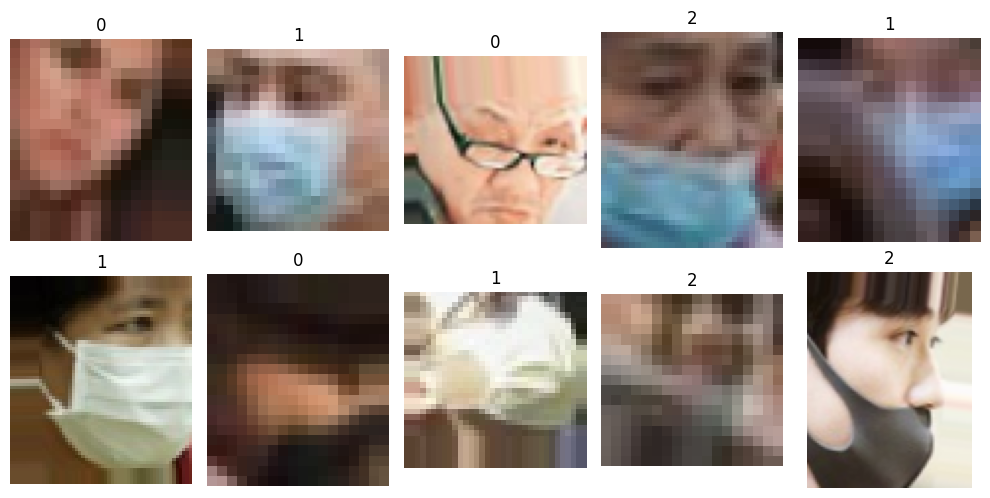

In [ ]:
import matplotlib.pyplot as plt
import random

# get 10 random images in the train images
random_indices = random.sample(range(len(balanced_images)), 10)

# display the 10 random images with labels from balanced data
fig, axes = plt.subplots(2, 5, figsize=(10, 5))

for i, ax in enumerate(axes.flat):
    normalized_image = balanced_images[random_indices[i]] / 255.0
    ax.imshow(normalized_image)
    ax.set_title(balanced_labels[random_indices[i]])
    ax.axis('off')

plt.tight_layout()
plt.show()

Resize, normalize, and grayscale train images

In [ ]:
from skimage.color import rgb2gray
from skimage.transform import resize
import numpy as np

def preprocess_images(images):
    # create list to add processed images
    processed_images = []
    # iterate through images
    for img in images:
        # convert to grayscale
        gray_img = rgb2gray(img)
        # resize image to 64x64
        resized_img = resize(gray_img, (64, 64))
        # nomrlized pixels
        normalized_img = resized_img / 255.0
        processed_images.append(normalized_img)
    return processed_images

# call function on balanced train images
processed_train_images = preprocess_images(balanced_images)

In [ ]:
# call preproccess function on validation images
processed_val_images = preprocess_images(val_images)

# call preprocess function on test images
processed_test_images = preprocess_images(test_images)

Check processed images

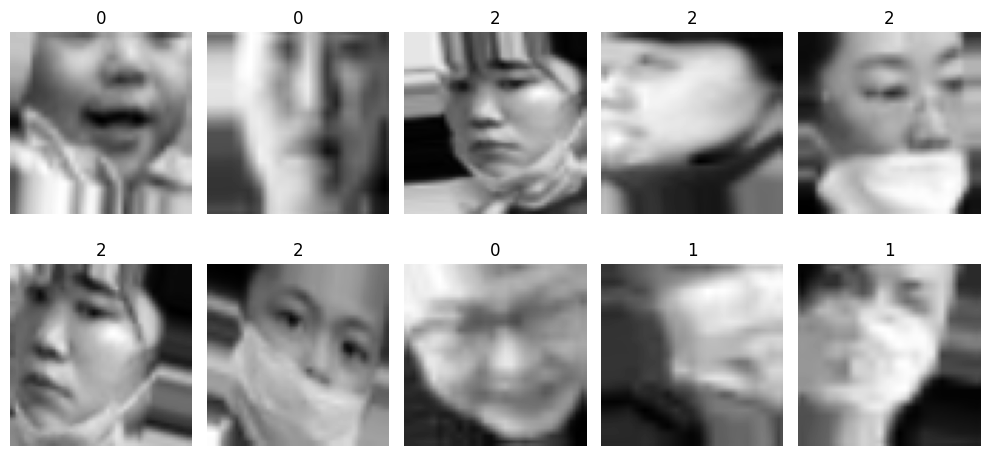

In [ ]:
import matplotlib.pyplot as plt
import random

# get 10 random images in the processed train images
random_indices = random.sample(range(len(processed_train_images)), 10)

# display the 10 random images with labels
fig, axes = plt.subplots(2, 5, figsize=(10, 5))

for i, ax in enumerate(axes.flat):
    ax.imshow(processed_train_images[random_indices[i]], cmap='gray')
    ax.set_title(balanced_labels[random_indices[i]])
    ax.axis('off')

plt.tight_layout()
plt.show()

#HOG + SVM model with rebalancing

## Grid search

In [ ]:
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

# extract HOG features for train images
train_hog_features = [hog(img, orientations=10, pixels_per_cell=(9, 9), cells_per_block=(3, 3), visualize=False) for img in processed_train_images]

# define parameters for grid search
param_grid = {
    'C': [0.1, 1, 5],  # regularization parameter
    #'kernel': ['linear','rbf'],  # kernel type
    'gamma': ['scale', 0.1, 1]  # kernel coefficient
}

# create svm classifer
svm_classifier = SVC(kernel='rbf')

# perform grid search with cross validation
grid_search = GridSearchCV(estimator=svm_classifier, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(train_hog_features, balanced_labels)

# get best params from grid search
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'C': 5, 'gamma': 'scale'}


## Train model

In [ ]:
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# extract HOG features for train images
train_hog_features = [hog(img, orientations=10, pixels_per_cell=(9, 9), cells_per_block=(3, 3), visualize=False) for img in processed_train_images]

# create svm classifer with best params from grid search and max iteration to prevent overfitting
svm_hog = SVC(kernel='rbf', C=5, gamma='scale', max_iter=1000)

# train model
svm_hog.fit(train_hog_features, balanced_labels)

# make predictions with training hog featres
y_pred = svm_hog.predict(train_hog_features)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [ ]:
from sklearn.metrics import classification_report

# get accuracy and classification report for training
accuracy = accuracy_score(balanced_labels, y_pred)
print("Accuracy:", accuracy)
report = classification_report(balanced_labels, y_pred)
print("Classification Report:")
print(report)

Accuracy: 0.9838709677419355
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      3844
           1       0.99      0.99      0.99      3844
           2       0.98      0.97      0.98      3844

    accuracy                           0.98     11532
   macro avg       0.98      0.98      0.98     11532
weighted avg       0.98      0.98      0.98     11532



In [ ]:
# extract HOG features from validation images
val_hog_features = [hog(img, orientations=10, pixels_per_cell=(9, 9), cells_per_block=(3, 3), visualize=False) for img in processed_val_images]

# make predictions on validation hog features
y_pred_val = svm_hog.predict(val_hog_features)


In [ ]:
# get accuracy and classification report on validation
accuracy = accuracy_score(val_labels, y_pred_val)
print("Accuracy:", accuracy)
report = classification_report(val_labels, y_pred_val)
print("Classification Report:")
print(report)

Accuracy: 0.7181628392484343
Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.61      0.54        62
           1       0.96      0.73      0.83       401
           2       0.13      0.75      0.22        16

    accuracy                           0.72       479
   macro avg       0.52      0.70      0.53       479
weighted avg       0.87      0.72      0.77       479



# HOG + SVM model without rebalancing - Used in test_functions and report

Try model without rebalancing the train data

In [ ]:
# preprocess train images without rebalancing
processed_train_images_nb = preprocess_images(train_images)

## Train model

In [ ]:
# extract HOG features for train images
train_hog_features_nb = [hog(img, orientations=10, pixels_per_cell=(9, 9), cells_per_block=(3, 3), visualize=False) for img in processed_train_images_nb]

# create svm classifer with best params from grid search and max iteration to prevent overfitting
svm_hog2 = SVC(kernel='rbf', C=5, gamma='scale', max_iter=1000)

# train model
svm_hog2.fit(train_hog_features_nb, train_labels)

# make predictions on train set
y_pred = svm_hog2.predict(train_hog_features_nb)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [ ]:
# extract HOG features from validation images
val_hog_features = [hog(img, orientations=10, pixels_per_cell=(9, 9), cells_per_block=(3, 3), visualize=False) for img in processed_val_images]

# make predictions on validation hog features
y_pred_val = svm_hog2.predict(val_hog_features)

# get accuracy and classification report for validation
accuracy = accuracy_score(val_labels, y_pred_val)
print("Accuracy:", accuracy)
report = classification_report(val_labels, y_pred_val)
print("Classification Report:")
print(report)

Accuracy: 0.8997912317327766
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.58      0.63        62
           1       0.92      0.97      0.95       401
           2       1.00      0.38      0.55        16

    accuracy                           0.90       479
   macro avg       0.87      0.64      0.71       479
weighted avg       0.90      0.90      0.89       479



## Test model

In [ ]:
# extract hog features from test images
test_hog_features = [hog(img, orientations=10, pixels_per_cell=(9, 9), cells_per_block=(3, 3), visualize=False) for img in processed_test_images]

# make predictions on test hog features
y_pred_test = svm_hog2.predict(test_hog_features)

# get accuracy and classification report for test
accuracy = accuracy_score(test_labels, y_pred_test)
print("Accuracy:", accuracy)
report = classification_report(test_labels, y_pred_test)
print("Classification Report:")
print(report)


Accuracy: 0.9104803493449781
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.59      0.68        51
           1       0.92      0.99      0.95       388
           2       1.00      0.21      0.35        19

    accuracy                           0.91       458
   macro avg       0.91      0.60      0.66       458
weighted avg       0.91      0.91      0.90       458



In [ ]:
import joblib

# save svm model
joblib.dump(svm_hog2, os.path.join(GOOGLE_DRIVE_PATH, 'Models/svm_hog.pkl'))

['drive/My Drive/CW_Folder_PG 2/Models/svm_hog.pkl']

# SIFT + SVM model

## SIFT functions

In [ ]:
import cv2
import numpy as np
from skimage import color, img_as_ubyte
from sklearn.cluster import MiniBatchKMeans

# code reference from lab
def sift_features(images, labels):

    # initialize SIFT detector
    sift = cv2.SIFT_create()

    # empty lists for feature descriptors and labels
    des_list = []
    y_train_list = []

    for i in range(len(images)):
        img = img_as_ubyte(color.rgb2gray(images[i])) # convert to grayscale
        kp, des = sift.detectAndCompute(img, None) # identify keypoints and extract descriptors with SIFT

        # add descriptors and labels to lists
        if des is not None:
            des_list.append(des)
            y_train_list.append(labels[i])

    # convert to numpy array
    des_array = np.vstack(des_list)

    # set number of codewords/centroids (10*num_classes)
    k = len(np.unique(labels)) * 10

    # set batch size for faster computation and less memory usage
    batch_size = des_array.shape[0] // 4
    kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size, n_init='auto').fit(des_array)

    hist_list = []
    idx_list = []

    # convert descriptors into histograms of codewords for each image
    for des in des_list:
        hist = np.zeros(k)
        idx = kmeans.predict(des)
        idx_list.append(idx)
        for j in idx:
            hist[j] = hist[j] + (1 / len(des))
        hist_list.append(hist)

    hist_array = np.vstack(hist_list)

    return hist_array, y_train_list, des_array



In [ ]:
import numpy as np
from skimage import color, img_as_ubyte

# code reference from lab
def sift_features_test(images, labels, des_array):
    hist_list = []
    # initialize SIFT detector
    sift = cv2.SIFT_create()

    # set number of codewords/centroids (10*num_classes)
    k = len(np.unique(labels)) * 10
    batch_size = des_array.shape[0] // 4
    kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size, n_init='auto').fit(des_array)

    for i in range(len(images)):
        img = img_as_ubyte(color.rgb2gray(images[i])) # convert to grayscale
        kp, des = sift.detectAndCompute(img, None) # identify keypoints and extract descriptors with SIFT

        if des is not None:
            hist = np.zeros(kmeans.n_clusters)

            idx = kmeans.predict(des)

            for j in idx:
                hist[j] = hist[j] + (1 / len(des))

            hist_list.append(hist)

        else:
            hist_list.append(None)

    # remove potential cases of images with no descriptors
    idx_not_empty = [i for i, x in enumerate(hist_list) if x is not None]
    hist_list = [hist_list[i] for i in idx_not_empty]
    hist_array = np.vstack(hist_list)

    return hist_array




SIFT on training set

In [ ]:
train_hist_array_sift, train_labels_list_sift, train_des_array = sift_features(train_images, train_labels)

In [ ]:
train_hist_array = sift_features_test(train_images, train_labels, train_des_array)

SIFT on validation set

In [ ]:
val_hist_array_sift, val_labels_list_sift, val_des_array = sift_features(val_images, val_labels)

In [ ]:
val_hist_array = sift_features_test(val_images, val_labels, val_des_array)

SIFT on test set

In [ ]:
test_hist_array_sift, test_labels_list_sift, test_des_array = sift_features(test_images, test_labels)

In [ ]:
test_hist_array = sift_features_test(test_images, test_labels, test_des_array)

## Grid search

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV

# define the param values for grid search
param_grid = {
    'C': [0.001, 0.1, 1, 10]  # regularization parameter
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001],  # kernel coefficient
}

# create svm model with rbf kernel
svm_sift = svm.SVC(kernel='rbf')

# grid search with cross validation
grid_search = GridSearchCV(estimator=svm_sift, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(train_hist_array_sift, train_labels_list_sift)

# get best parameters
print("Best parameters found:")
print(grid_search.best_params_)


Best parameters found:
{'C': 1, 'gamma': 'scale'}


## Train model

In [ ]:
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


# create svm model with best params from grid search
svm_sift = SVC(kernel='rbf', C=1, gamma='scale')

# train model
svm_sift.fit(train_hist_array_sift, train_labels_list_sift)


SVC(C=1)

In [ ]:
# make predicitons on validation
y_pred_val = svm_sift.predict(val_hist_array)

# get accuracy and classification report for validaiton
accuracy_val = accuracy_score(val_labels_list_sift, y_pred_val)
print("Validation Accuracy:", accuracy_val)
report_val = classification_report(val_labels_list_sift, y_pred_val)
print("Classification Report on Validation Set:")
print(report_val)

Validation Accuracy: 0.828752642706131
Classification Report on Validation Set:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.84      0.99      0.91       397
           2       0.00      0.00      0.00        16

    accuracy                           0.83       473
   macro avg       0.28      0.33      0.30       473
weighted avg       0.70      0.83      0.76       473



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Test model

In [ ]:
# make predictions on test set
y_pred_test = svm_sift.predict(test_hist_array)

In [ ]:
# get accuracy and classification report for test
accuracy_val = accuracy_score(test_labels_list_sift, y_pred_test)
print("Validation Accuracy:", accuracy_val)
report_val = classification_report(test_labels_list_sift, y_pred_test)
print("Classification Report on Validation Set:")
print(report_val)

Validation Accuracy: 0.8322295805739515
Classification Report on Validation Set:
              precision    recall  f1-score   support

           0       0.17      0.04      0.06        50
           1       0.85      0.98      0.91       384
           2       0.00      0.00      0.00        19

    accuracy                           0.83       453
   macro avg       0.34      0.34      0.32       453
weighted avg       0.74      0.83      0.78       453



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import joblib

# save model
joblib.dump(svm_sift, os.path.join(GOOGLE_DRIVE_PATH, 'Models/svm_sift.pkl'))

['drive/My Drive/CW_Folder_PG 2/Models/svm_sift.pkl']